# CS 440/540 Machine Learning in Finance: Homework 3

Download data files from LMS. Code/Explain your solution over this `IPython` notebook at required cells, and complete locally.

To submit your assignment, in LMS, upload your solution to LMS as a single notebook with following file name format:

`lastName_firstName_CourseNumber_HW3.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 440 or CS 540).

Problems on homework assignments are equally weighted.

Any type of plagiarism will not be tolerated. Your submitted codes will be compared with other submissions and also the codes available on internet and violations will have a penalty of -100 points. (In case of copying from
another student both parties will get -100)

Import all libraries here

In [2]:
#Import libraries before starting
import pandas as pd
import numpy as np

## Problem 1: Cryptocurrency Trading via Multivariate AR (VAR)

In this question, you model the price dynamics of multiple cryptocurrencies jointly via multivariate AR (Vector AR). You will focus only on BTC, ETH, LTC, SOL, AVAX, BNB. You can download the historical cryptocurrency price data from www.coinmarketcap.com or Yahoo Finance. Since cryptocurrency markets are 7/24, you will be using the latest data in UTC time as the close price.

You will predict these cryptocurrency prices by VAR. You do not need to implement ARMA from scratch; you can use the existing implementation in statsmodels. Our training period 2021-2022 and test period will be 2022-2023. Once predicted after training, our portfolio will be allocated to the top two cryptocurrencies with the highest return estimation.

You will report the best model in terms of Information Ratio by considering the parameters p,q in ranges [0, 1, 5].

In [194]:
import yfinance as yf

cryptos = ["BTC-USD", "ETH-USD", "LTC-USD", "SOL-USD", "AVAX-USD", "BNB-USD"]

train_start = "2021-01-01"
train_end = "2022-12-31"
test_start = "2023-01-01"
test_end = "2023-11-30"

for crypto in cryptos:
    print(f"Downloading data for {crypto}...")
    
    train_data = yf.download(crypto, start=train_start, end=train_end, interval="1d")
    train_data.reset_index(inplace=True)
    train_filename = f"{crypto.split('-')[0]}_train.csv"
    train_data.to_csv(train_filename, index=False)
    
    test_data = yf.download(crypto, start=test_start, end=test_end, interval="1d")
    test_data.reset_index(inplace=True)
    test_filename = f"{crypto.split('-')[0]}_test.csv"
    test_data.to_csv(test_filename, index=False)

    print(f"Data for {crypto} saved as {train_filename} and {test_filename}!")

print("All data downloaded successfully!")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for BTC-USD saved as BTC_train.csv and BTC_test.csv!
Data for ETH-USD saved as ETH_train.csv and ETH_test.csv!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data for LTC-USD saved as LTC_train.csv and LTC_test.csv!
Data for SOL-USD saved as SOL_train.csv and SOL_test.csv!


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Data for AVAX-USD saved as AVAX_train.csv and AVAX_test.csv!
Data for BNB-USD saved as BNB_train.csv and BNB_test.csv!
All data downloaded successfully!


In [195]:
cryptos = ["BTC", "ETH", "LTC", "SOL", "AVAX", "BNB"]

train_dataset = []
test_dataset = []

for crypto in cryptos:

    train_file = f"{crypto}_train.csv"
    test_file = f"{crypto}_test.csv"
    
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])
    
    train_data = train_data[['Date', 'Close']].rename(columns={'Close': f"{crypto}_close"})
    test_data = test_data[['Date', 'Close']].rename(columns={'Close': f"{crypto}_close"})
    train_dataset.append(train_data)
    test_dataset.append(test_data)


In [196]:
train_data_merged = train_dataset[0]
for data in train_dataset[1:]:
    train_data_merged = pd.merge(train_data_merged, data, on="Date", how="outer")

In [197]:
test_data_merged = test_dataset[0]
for data in test_dataset[1:]:
    test_data_merged = pd.merge(test_data_merged, data, on="Date", how="outer")

In [198]:
train_data_merged.sort_values(by="Date", inplace=True)
test_data_merged.sort_values(by="Date", inplace=True)

In [199]:
train_data_merged.reset_index(drop=True, inplace=True)
test_data_merged.reset_index(drop=True, inplace=True)

In [200]:
train_data_merged.to_csv("train_data.csv", index=False)
test_data_merged.to_csv("test_data.csv", index=False)

In [201]:
train_data = pd.read_csv("train_data.csv")
test_data = pd.read_csv("test_data.csv")

In [202]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

In [203]:
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

In [204]:
train_returns = train_data.pct_change().dropna()

In [205]:
average_returns = train_returns.mean().sort_values(ascending=False)

In [206]:
top_2_currencies = average_returns.index[:2]
print(f"Top 2 currencies based on average returns: {list(top_2_currencies)}")

Top 2 currencies based on average returns: ['SOL_close', 'AVAX_close']


In [207]:
train_top2 = train_returns[top_2_currencies]
test_top2 = test_data[top_2_currencies].pct_change().dropna()

In [218]:
train_top2.index = pd.to_datetime(train_top2.index)
test_top2.index = pd.to_datetime(test_top2.index)

train_top2 = train_top2.asfreq('D') # for solving the warning, frequency not initialized
test_top2 = test_top2.asfreq('D')

In [220]:
train_top2.shape

(728, 2)

In [221]:
train_top2.head()

,SOL_close,AVAX_close
Date,,
2021-01-02,-0.023239,-0.046355
2021-01-03,0.201457,-0.006294
2021-01-04,0.149575,0.033775
2021-01-05,-0.131938,0.180258
2021-01-06,-0.105692,0.090372


In [222]:
lags_to_test = [1, 5]  

best_ir = -np.inf 
best_lag = None
best_model = None
forecast_returns_best = None

In [223]:
from statsmodels.tsa.api import VAR

for p in lags_to_test:
    print(f"Fitting VAR model with lag order {p}...")
    
    var_model = VAR(train_top2)
    model_fitted = var_model.fit(p)
    
    forecast = model_fitted.forecast(train_top2.values, steps=len(test_top2))
    forecast_returns = pd.DataFrame(forecast, index=test_top2.index, columns=top_2_currencies)
    
    portfolio_returns = forecast_returns.mean(axis=1)
    average_portfolio_return = portfolio_returns.mean()
    portfolio_volatility = portfolio_returns.std()
    
    information_ratio = average_portfolio_return / portfolio_volatility
    
    print(f"Information Ratio for p={p}: {information_ratio:.4f}")
    
    if information_ratio > best_ir:
        best_ir = information_ratio
        best_lag = p
        best_model = model_fitted
        forecast_returns_best = forecast_returns

print(f"\nBest lag order: {best_lag}")
print(f"Best Information Ratio: {best_ir:.4f}")

Fitting VAR model with lag order 1...
Information Ratio for p=1: 56.3426
Fitting VAR model with lag order 5...
Information Ratio for p=5: 5.4108

Best lag order: 1
Best Information Ratio: 56.3426


In [224]:
forecast_returns_best.head()

,SOL_close,AVAX_close
Date,,
2023-01-02,0.004388,0.002256
2023-01-03,0.005160,0.004593
2023-01-04,0.005159,0.004652
2023-01-05,0.005160,0.004655
2023-01-06,0.005160,0.004655


In [226]:
from statsmodels.tsa.api import VAR

train_data = train_top2 
top_2_currencies = ['SOL_close', 'AVAX_close']  
test_data = test_top2 

var_model = VAR(train_data[top_2_currencies])
model_fitted = var_model.fit(best_lag)

forecasted_returns = []

last_observation = train_data[top_2_currencies].iloc[-best_lag:]

for t in range(len(test_data)):
    forecast_step = model_fitted.forecast(last_observation.values.reshape(1, -1), steps=1)
    
    forecasted_returns.append(forecast_step[0])
    
    last_observation = pd.DataFrame([forecast_step[0]], columns=top_2_currencies, index=[test_data.index[t]])

forecast_returns_best = pd.DataFrame(forecasted_returns, index=test_data.index, columns=top_2_currencies)


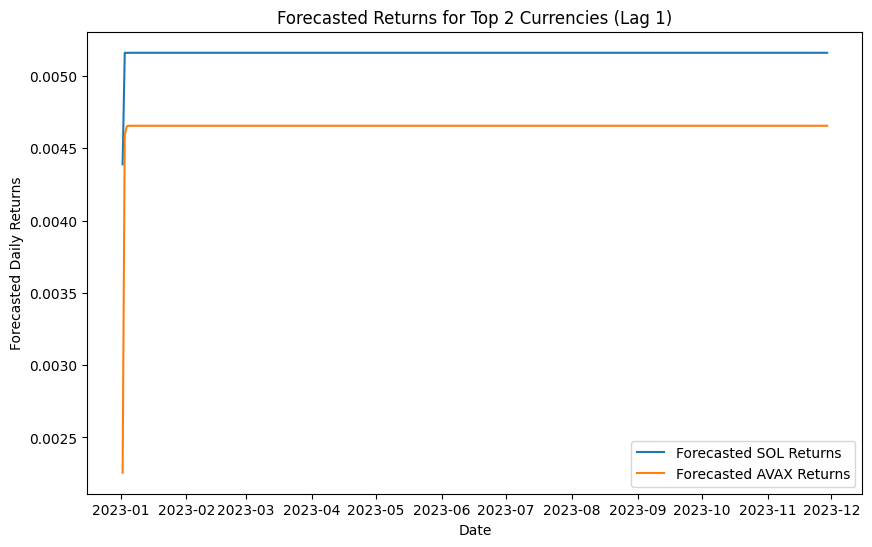

In [229]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(forecast_returns_best.index, forecast_returns_best['SOL_close'], label="Forecasted SOL Returns")
plt.plot(forecast_returns_best.index, forecast_returns_best['AVAX_close'], label="Forecasted AVAX Returns")

# Add labels and title
plt.legend()
plt.title(f"Forecasted Returns for Top 2 Currencies (Lag {best_lag})")
plt.xlabel('Date')
plt.ylabel('Forecasted Daily Returns')

# Show the plot
plt.show()

## Problem 2: MLP for Detecting Fraudulent Transactions

In this problem, we will focus on predicting whether a transaction is a fraud or not. All transactions are provided in "transactions.csv". The file contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, original features cannot be provided. Features V1, V2, …, V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount; this feature can be used for example-dependent cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Analyze the dataset. Do you think the dataset is balanced? Evaluate and compare the following 2 MLP architectures without SMOTE, as well as after balancing the data via SMOTE. You can compare performance by F1 score and use 5-fold cross-validation for hyperparameter optimization.

a- MLP with 1 hidden layer with 8 units in hidden layer

b- MLP with 2 hidden layers with 8 units in first layer and 4 units in the second layer.

In [74]:
data = pd.read_csv('transactions.csv')

In [75]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [77]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

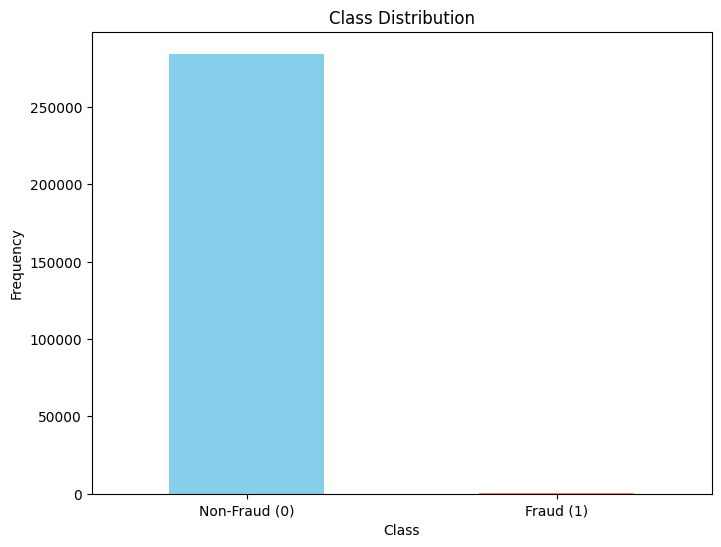

In [78]:
import matplotlib.pyplot as plt

class_distribution = data['Class'].value_counts()

plt.figure(figsize=(8,6))
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.show()

In [79]:
print("Class distribution (counts):")
print(class_distribution)

print("\nClass distribution (percentage):")
print(class_distribution / len(data) * 100)

Class distribution (counts):
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution (percentage):
Class
0    99.827251
1     0.172749
Name: count, dtype: float64


##### There is a significant imbalance for the dataset. Fraud class is not represented well like in overall dataset the %0.17 of the data is for Fraud class but %99.82 is for Non-Fraud class.

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# separate columns for features and target
X = data.drop(columns=['Class']) 
y = data['Class']

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [83]:
# There are only numerical values after PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
from sklearn.neural_network import MLPClassifier

model_1 = MLPClassifier(hidden_layer_sizes=(8,), random_state=42, max_iter=1000)
model_2 = MLPClassifier(hidden_layer_sizes=(8, 4), random_state=42, max_iter=1000)

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import  cross_val_score

def train_and_evaluate(model, X_train, y_train):

    pipeline = Pipeline(steps=[('scaler', StandardScaler()),  
                               ('model', model)])  
    
    pipeline.fit(X_train, y_train)
    
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
    mean_f1_score = np.mean(cv_scores)
    return mean_f1_score, cv_scores

In [89]:
f1_score_1_before, cv_scores_1_before = train_and_evaluate(model_1, X_train, y_train)
print(f"MLP Model 1 (Before SMOTE) - F1 Scores: {cv_scores_1_before}")
print(f"Mean F1 Score for MLP Model 1 (Before SMOTE): {f1_score_1_before:.4f}")

MLP Model 1 (Before SMOTE) - F1 Scores: [0.81879195 0.77941176 0.82119205 0.79452055 0.81290323]
Mean F1 Score for MLP Model 1 (Before SMOTE): 0.8054


In [90]:
f1_score_2_before, cv_scores_2_before = train_and_evaluate(model_2, X_train, y_train)
print(f"MLP Model 2 (Before SMOTE) - F1 Scores: {cv_scores_2_before}")
print(f"Mean F1 Score for MLP Model 2 (Before SMOTE): {f1_score_2_before:.4f}")

MLP Model 2 (Before SMOTE) - F1 Scores: [0.84137931 0.79136691 0.80821918 0.81578947 0.82051282]
Mean F1 Score for MLP Model 2 (Before SMOTE): 0.8155


In [84]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE for balancing the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

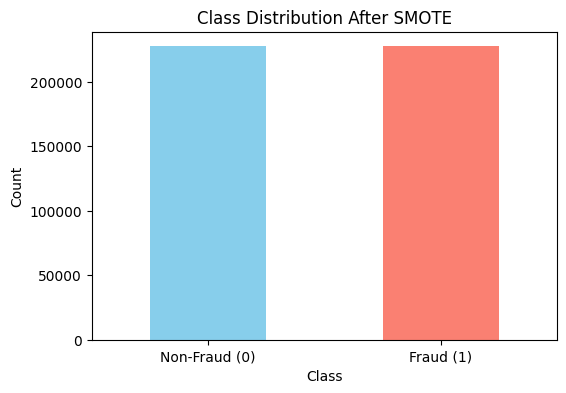

In [85]:
# Plot the class distribution after SMOTE balancing
plt.figure(figsize=(6, 4))
y_train_smote.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'], rotation=0)
plt.show()

In [86]:
print("\nClass Distribution After SMOTE (Counts):")
print(y_train_smote.value_counts())

print("\nClass Distribution After SMOTE (Percentage):")
print(y_train_smote.value_counts(normalize=True) * 100)


Class Distribution After SMOTE (Counts):
Class
0    227451
1    227451
Name: count, dtype: int64

Class Distribution After SMOTE (Percentage):
Class
0    50.0
1    50.0
Name: proportion, dtype: float64


In [91]:
f1_score_1_after, cv_scores_1_after = train_and_evaluate(model_1, X_train_smote, y_train_smote)
print(f"MLP Model 1 (After SMOTE) - F1 Scores: {cv_scores_1_after}")
print(f"Mean F1 Score for MLP Model 1 (After SMOTE): {f1_score_1_after:.4f}")

MLP Model 1 (After SMOTE) - F1 Scores: [0.99468499 0.99518793 0.99453588 0.99401014 0.99577791]
Mean F1 Score for MLP Model 1 (After SMOTE): 0.9948


In [92]:
f1_score_2_after, cv_scores_2_after = train_and_evaluate(model_2, X_train_smote, y_train_smote)
print(f"MLP Model 2 (After SMOTE) - F1 Scores: {cv_scores_2_after}")
print(f"Mean F1 Score for MLP Model 2 (After SMOTE): {f1_score_2_after:.4f}")

MLP Model 2 (After SMOTE) - F1 Scores: [0.99391871 0.99559703 0.99379018 0.99402299 0.99532162]
Mean F1 Score for MLP Model 2 (After SMOTE): 0.9945


#####  ---------------------------Those values for test set----------------------------------------

In [93]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return f1, precision, recall, accuracy

In [95]:
f1_before_1, precision_before_1, recall_before_1, accuracy_before_1 = evaluate_model(model_1, X_train_scaled, X_test_scaled, y_train, y_test)
print("MLP Model 1 (Before SMOTE) - F1 Score:", f1_before_1)
print("MLP Model 1 (Before SMOTE) - Precision:", precision_before_1)
print("MLP Model 1 (Before SMOTE) - Recall:", recall_before_1)
print("MLP Model 1 (Before SMOTE) - Accuracy:", accuracy_before_1)

MLP Model 1 (Before SMOTE) - F1 Score: 0.8021390374331551
MLP Model 1 (Before SMOTE) - Precision: 0.8426966292134831
MLP Model 1 (Before SMOTE) - Recall: 0.7653061224489796
MLP Model 1 (Before SMOTE) - Accuracy: 0.9993504441557529


In [96]:
f1_before_2, precision_before_2, recall_before_2, accuracy_before_2 = evaluate_model(model_2, X_train_scaled, X_test_scaled, y_train, y_test)

In [97]:
print("\nMLP Model 2 (Before SMOTE) - F1 Score:", f1_before_2)
print("MLP Model 2 (Before SMOTE) - Precision:", precision_before_2)
print("MLP Model 2 (Before SMOTE) - Recall:", recall_before_2)
print("MLP Model 2 (Before SMOTE) - Accuracy:", accuracy_before_2)


MLP Model 2 (Before SMOTE) - F1 Score: 0.7784431137724551
MLP Model 2 (Before SMOTE) - Precision: 0.9420289855072463
MLP Model 2 (Before SMOTE) - Recall: 0.6632653061224489
MLP Model 2 (Before SMOTE) - Accuracy: 0.9993504441557529


In [98]:
f1_after_1, precision_after_1, recall_after_1, accuracy_after_1 = evaluate_model(model_1, X_train_smote, X_test_scaled, y_train_smote, y_test)

In [99]:
print("\nMLP Model 1 (After SMOTE) - F1 Score:", f1_after_1)
print("MLP Model 1 (After SMOTE) - Precision:", precision_after_1)
print("MLP Model 1 (After SMOTE) - Recall:", recall_after_1)
print("MLP Model 1 (After SMOTE) - Accuracy:", accuracy_after_1)


MLP Model 1 (After SMOTE) - F1 Score: 0.2953020134228188
MLP Model 1 (After SMOTE) - Precision: 0.17670682730923695
MLP Model 1 (After SMOTE) - Recall: 0.8979591836734694
MLP Model 1 (After SMOTE) - Accuracy: 0.9926266633896281


In [100]:
f1_after_2, precision_after_2, recall_after_2, accuracy_after_2 = evaluate_model(model_2, X_train_smote, X_test_scaled, y_train_smote, y_test)

In [101]:

print("\nMLP Model 2 (After SMOTE) - F1 Score:", f1_after_2)
print("MLP Model 2 (After SMOTE) - Precision:", precision_after_2)
print("MLP Model 2 (After SMOTE) - Recall:", recall_after_2)
print("MLP Model 2 (After SMOTE) - Accuracy:", accuracy_after_2)


MLP Model 2 (After SMOTE) - F1 Score: 0.4029126213592233
MLP Model 2 (After SMOTE) - Precision: 0.2643312101910828
MLP Model 2 (After SMOTE) - Recall: 0.8469387755102041
MLP Model 2 (After SMOTE) - Accuracy: 0.9956813314139251


## Problem 3: MLP for House Price Prediction

Let's focus on the same Real State Price dataset from HW1 and HW2. In this problem, you are provided a single dataset "kaggle_house.csv" which includes both train and test sets. We will now implement four MLPs: 

a- MLP with 1 hidden layer with 8 units in hidden layer

b- MLP with 1 hidden layer with 4 units in hidden layer

c- MLP with 2 hidden layers with 4 units in both first and second layers.

d- MLP with 2 hidden layers with 8 units in first layer and 4 units in the second layer.

We will predict house sale price (last column) by using the following attributes: "SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea","Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF". Report the performance in terms of R2 and RMSE for the test set by applying 5-fold cross-validation.

Note that you need to carefully tune learning rate and number of epochs. 

In [32]:
data = pd.read_csv('kaggle_house.csv')

In [33]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [34]:
data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [35]:
columns = ["MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Street", 
           "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF", "SalePrice"]
data_columns = data[columns]

In [36]:
data_columns.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,YearBuilt,LotShape,1stFlrSF,2ndFlrSF,SalePrice
0,60,RL,65.0,8450,Pave,2003,Reg,856,854,208500
1,20,RL,80.0,9600,Pave,1976,Reg,1262,0,181500
2,60,RL,68.0,11250,Pave,2001,IR1,920,866,223500
3,70,RL,60.0,9550,Pave,1915,IR1,961,756,140000
4,60,RL,84.0,14260,Pave,2000,IR1,1145,1053,250000


In [37]:
data_columns.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'YearBuilt', 'LotShape', '1stFlrSF', '2ndFlrSF', 'SalePrice'],
      dtype='object')

In [38]:
# separate target features
features = data_columns.drop("SalePrice", axis=1)
target = data_columns['SalePrice']

In [39]:
# Check NA values before model creation
categorical_columns =  features.select_dtypes(include=['object', 'category']).columns
numerical_columns = features.select_dtypes(include=['int64', 'float64']).columns

In [40]:
categorical_columns

Index(['MSZoning', 'Street', 'LotShape'], dtype='object')

In [41]:
numerical_columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'YearBuilt', '1stFlrSF',
       '2ndFlrSF'],
      dtype='object')

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

numerical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  
    ('scaler', StandardScaler())
])

categorical_imputer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [43]:
from sklearn.compose import ColumnTransformer

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_imputer, numerical_columns), # apply numeric transforms to numerical features
        ('categorical', categorical_imputer, categorical_columns) # apply categorical transforms to categorical features
    ])

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=0)

In [45]:
X_train.shape, X_test.shape

((1168, 9), (292, 9))

In [46]:
y_train.shape, y_test.shape

((1168,), (292,))

In [52]:
max_iter_1 = 1000 # not converged yet with this

In [57]:
max_iter_2 = 10000 # not converged yet 

In [58]:
max_iter_3 = 50000 # with this iteration it give better results and rather than first model, others not give the warning of not converged yet

In [65]:
max_iter_4 = 100000 # for model 1 to convergence

In [59]:
from sklearn.neural_network import MLPRegressor

MLP_1_layer_8_units = MLPRegressor(hidden_layer_sizes=(8,), max_iter=max_iter_3,learning_rate_init=0.001, random_state=42)
MLP_1_layer_4_units = MLPRegressor(hidden_layer_sizes=(4,), max_iter=max_iter_3,learning_rate_init=0.001, random_state=42)
MLP_2_layers_4_units =MLPRegressor(hidden_layer_sizes=(4, 4), max_iter=max_iter_3, learning_rate_init=0.001,random_state=42)
MLP_2_layers_8_4_units = MLPRegressor(hidden_layer_sizes=(8, 4), max_iter=max_iter_3, learning_rate_init=0.001,random_state=42)

In [60]:
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score
from math import sqrt

def train(model):
    pipeline = Pipeline(steps=[('preprocessor', data_transformer),
                               ('model', model)])
    
    pipeline.fit(X_train, y_train)
    
    scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    rmse_scores = cross_val_score(pipeline, X_train, y_train, cv=5, 
                                  scoring=make_scorer(mean_squared_error))
    average_r2 = np.mean(scores)
    average_rmse = sqrt(np.mean(rmse_scores))

    print(f"Average R2 score: {average_r2}")
    print(f"Average RMSE: {average_rmse}")

In [61]:
print("MLP with 1 hidden layer (8 units):")
train(MLP_1_layer_8_units)

MLP with 1 hidden layer (8 units):


/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50000) reached and the 

Average R2 score: 0.722010489572471
Average RMSE: 41313.570463880795


In [72]:
MLP_1_layer_8_units_max_iter_change = MLPRegressor(hidden_layer_sizes=(8,), max_iter=max_iter_4,learning_rate_init=0.001, random_state=42)

In [73]:
print("MLP with 1 hidden layer (8 units) max iteration is 100000 for convergence:")
train(MLP_1_layer_8_units_max_iter_change)

MLP with 1 hidden layer (8 units) max iteration is 100000 for convergence:


/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/beyzakaya/miniforge3/envs/finance-ml/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100000) reached and 

Average R2 score: 0.7185198015483685
Average RMSE: 41594.11161736424


In [69]:
print("MLP with 1 hidden layer (4 units):")
train(MLP_1_layer_4_units)

MLP with 1 hidden layer (4 units):
Average R2 score: 0.7235474406423685
Average RMSE: 41188.51254509863


In [70]:
print("MLP with 2 hidden layers (4 units for two layers):")
train(MLP_2_layers_4_units)

MLP with 2 hidden layers (4 units for two layers):
Average R2 score: 0.7240093177938633
Average RMSE: 41150.33608736419


In [71]:
print("MLP with 2 hidden layers (8 units for first layer, 4 units second layer):")
train(MLP_2_layers_8_4_units)

MLP with 2 hidden layers (8 units for first layer, 4 units second layer):
Average R2 score: 0.723658357746825
Average RMSE: 41176.75926672136


##### Max iteration as 50000 is better even with not converged warning for the model MLP_1_layer_8_units.